# Projektin alustus

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import files

In [3]:
!pip install shap

In [4]:
!pip install pandas scikit-learn statsmodels fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.9 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=76fefb89ead6fc0c78de02e1cc82a56b37ce198eec70d760485738fbef6dd63e
  Stored in directory: /root/.cache/pip/wheels/1a/f3/a1/f7f10b5ae2c2459398762a3fcf4ac18c325311c7e3163d5a15
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=a3581901297de62cb1a5497123b510ac36fc81765d3c063e9a346fe9d1d1eae1
  Stored in directory: /root/.cache/pip/wheels/ea/e8/e0/79872972161e54486517ae507f94b2c7cea27fb7ef793bd415
Successfully built fancyimpute knnimpute


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from fancyimpute import IterativeImputer
from scipy.stats import boxcox
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import shap


/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Datan esikäsittely

In [241]:
import pandas as pd

# TO-DO: Alusta tähän datasetin lukeminen ja tallenna se nimellä df

file_path = '/content/drive/MyDrive/Dippa/DATATIE-latausasemat.csv'
df = pd.read_csv(file_path, delimiter = ";")


In [242]:
df.columns

Index(['FID', 'Naiset', 'Miehet', 'Ko_perus', 'Ko_yliop', 'Ko_ammat',
       'Ko_al_kork', 'Ko_yl_kork', 'Tp_tyopy', 'Ra_pt_as', 'Ra_kt_as',
       'Ra_muu_as', 'Pt_tyoll', 'Pt_tyott', 'Viipyma_arki', 'Viipyma_vkl',
       'AC_laturit', 'DC_laturit', 'count_Acc_First', 'count_Business_First',
       'count_Eat_First', 'count_Gov_First', 'count_Health_First',
       'count_Leisure_First', 'count_Shop1_First', 'count_Shop2_First',
       'count_Sport_First', 'count_Tourism_First', 'count_Trans_First',
       'KAC_First', 'KDC_First', 'Kvl2_First', 'Hr_mtu_First', 'Kika2_First',
       'Te_takk2_First', 'Pistokkeet'],
      dtype='object')

In [243]:
df = df.drop(columns = ["Pistokkeet"])

df = df.rename(columns = {"count_Acc_First": "Majoittuminen", "count_Business_First": "Liiketoiminta", "count_Eat_First": "Ruoka ja juoma",
                    "count_Gov_First": "Hallinto", "count_Health_First": "Terveys", "count_Leisure_First": "Vapaa-aika", "count_Shop1_First": "Ostoskeskittymät",
                     "count_Shop2_First": "Ostokset", "count_Sport_First": "Urheilu", "count_Tourism_First": "Turismi", "count_Trans_First": "Liikenne",
                     "KAC_First": "AC-kilpailu", "KDC_First": "DC-kilpailu", "Kvl2_First": "Liikennemäärä", "Hr_mtu_First": "Mediaanitulot", "Kika2_First": "Keski-ikä", "Te_takk2_First": "Talouden keskikoko",
                     "Tp_tyopy": "Työpaikat", "Ra_pt_as": "Pientaloasunnot", "Ra_kt_as": "Kerrostaloasunnot", "Ra_muu_as": "Muut asunnot", "Pt_tyoll": "Työlliset", "Pt_tyott": "Työttömät", "AC_laturit": "Hitaat laturit",
                     "DC_laturit": "Nopeat laturit", "Ko_perus": "Peruskoulu", "Ko_yliop": "Ylioppilaat", "Ko_ammat": "Ammattikoulu", "Ko_al_kork": "Alempi kk", "Ko_yl_kork": "Ylempi kk"
})

In [244]:
df['Keski-ikä'] = df['Keski-ikä'].str.replace(',', '.').astype(float)
df['Talouden keskikoko'] = df['Talouden keskikoko'].str.replace(',', '.').astype(float)

In [245]:
df.dtypes

,0
FID,int64
Naiset,float64
Miehet,float64
Peruskoulu,float64
Ylioppilaat,float64
Ammattikoulu,float64
Alempi kk,float64
Ylempi kk,float64
Työpaikat,float64
Pientaloasunnot,float64


# Feature engineering

In [246]:
# TO-DO: laske halutessasi lisää johdannaiskolumneja
# esim työllisyys/työttömyysaste, koulutusaste tai
# ynnää yhteen eri kolumneja
df["Kävijämäärä"] = (df["Viipyma_arki"] + df["Viipyma_vkl"]) / 2
df["Asukasluku"] = df["Miehet"] + df["Naiset"]

poi_columns = ["Liiketoiminta", "Hallinto", "Terveys", "Vapaa-aika", "Urheilu", "Turismi", "Liikenne", "Majoittuminen"]
df["Kohdepisteet"] = df[poi_columns].sum(axis=1)

df = df.drop(columns = ["Viipyma_arki", "Viipyma_vkl", "Miehet", "Naiset", "Liiketoiminta", "Hallinto", "Terveys",
                        "Vapaa-aika", "Urheilu", "Turismi", "Liikenne", "Majoittuminen"])

<Axes: >

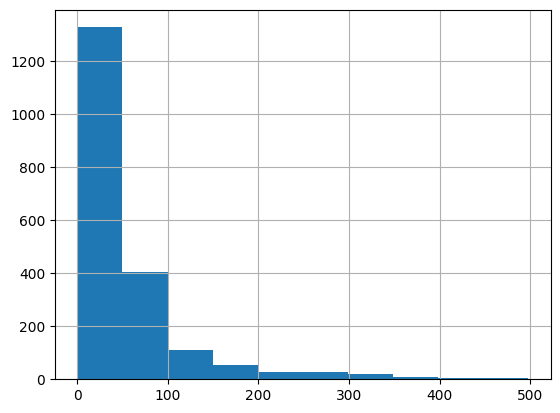

In [247]:
df['Kohdepisteet'].hist()

In [248]:
# Categorize stations based on amount of POIs near the station

# TO-DO: Valitse sopivan kokoiset luokat kategorisointiin
# Muuta lukuja 10, 20, 30 tarvittaessa. Pyri saamaan
# kategorioista mahdollisimman tasakokoiset
# Define bins and labels
bins = [-1, 10, 20, 30, np.inf]  # Define the bin edges
labels = ["1", "2", "3", "4"]  # Define labels for each bin

# Apply binning
df["Kohdepisteet_kat"] = pd.cut(df["Kohdepisteet"], bins=bins, labels=labels)

# Verify results
print(df[["Kohdepisteet", "Kohdepisteet_kat"]].head(15))

    Kohdepisteet Kohdepisteet_kat
0             63                4
1             79                4
2            125                4
3             75                4
4             39                4
5             13                2
6             17                2
7             84                4
8             62                4
9             10                1
10            68                4
11            51                4
12            58                4
13           143                4
14           163                4


<Axes: >

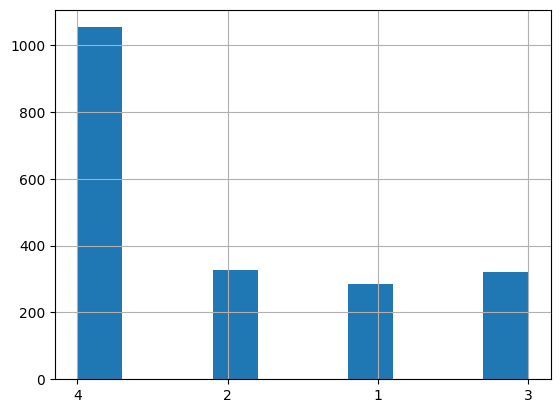

In [249]:
df['Kohdepisteet_kat'].hist()

In [250]:
df = df.drop(columns = ["Kohdepisteet"])
df["Kohdepisteet_kat"] = df["Kohdepisteet_kat"].astype(int)

# Data transformations

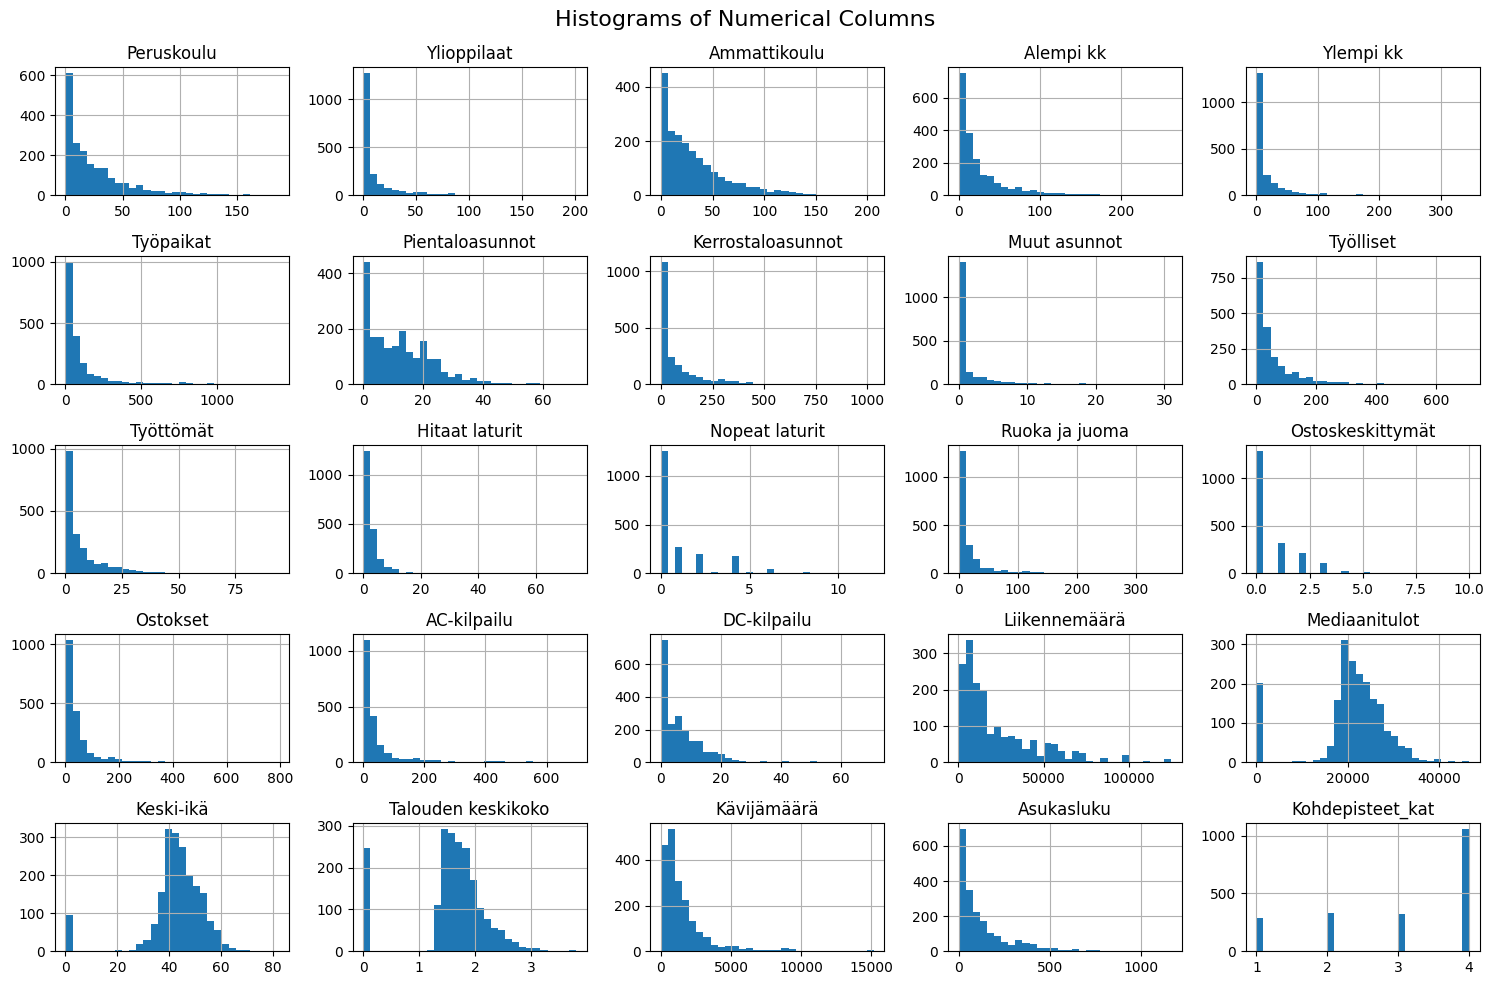

In [251]:
# Plot histograms for all numerical columns
df_hist = df.drop(columns = ["FID"])
df_hist.hist(bins=30, figsize=(15, 10))

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Reserve space for subtitle
plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.show()

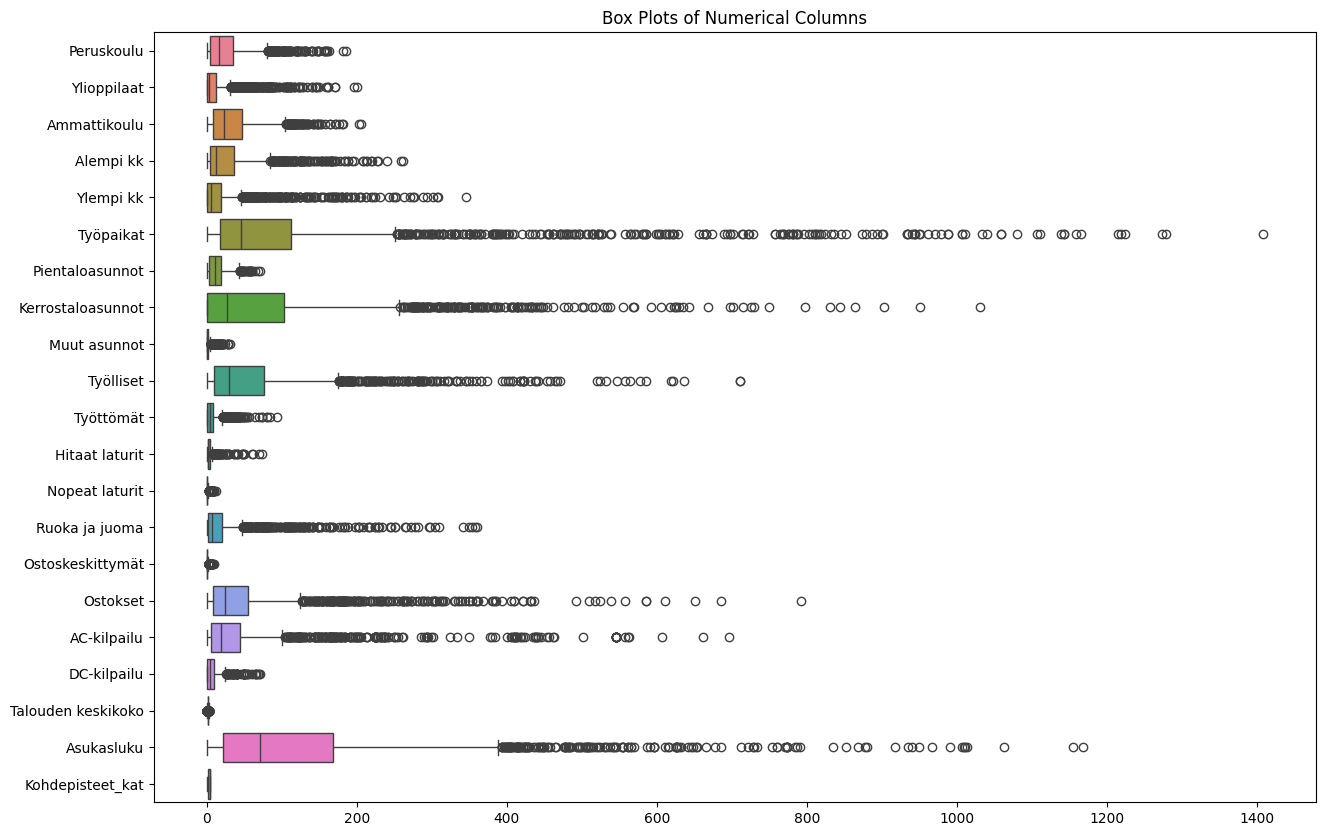

In [252]:
df_outliers = df.drop(columns = ["FID", "Mediaanitulot", "Liikennemäärä", "Kävijämäärä", "Keski-ikä"])

# Plot box plots for all numerical columns
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_outliers, orient='h')
plt.title('Box Plots of Numerical Columns')
plt.show()


In [253]:
# Summary statistics for all numerical columns
summary_stats = df.describe().T
summary_stats['skew'] = df.skew()
summary_stats['kurtosis'] = df.kurtosis()

print(summary_stats['skew'])


FID                   0.002309
Peruskoulu            1.914612
Ylioppilaat           3.141130
Ammattikoulu          1.521250
Alempi kk             2.477488
Ylempi kk             3.686483
Työpaikat             3.074621
Pientaloasunnot       1.163269
Kerrostaloasunnot     2.701447
Muut asunnot          3.290709
Työlliset             2.953710
Työttömät             2.781540
Hitaat laturit        7.170357
Nopeat laturit        2.115912
Ruoka ja juoma        4.120310
Ostoskeskittymät      2.333516
Ostokset              3.569378
AC-kilpailu           3.827723
DC-kilpailu           2.860225
Liikennemäärä         1.663727
Mediaanitulot        -1.233327
Keski-ikä            -1.977720
Talouden keskikoko   -1.094696
Kävijämäärä           3.235830
Asukasluku            2.297118
Kohdepisteet_kat     -0.763554
Name: skew, dtype: float64


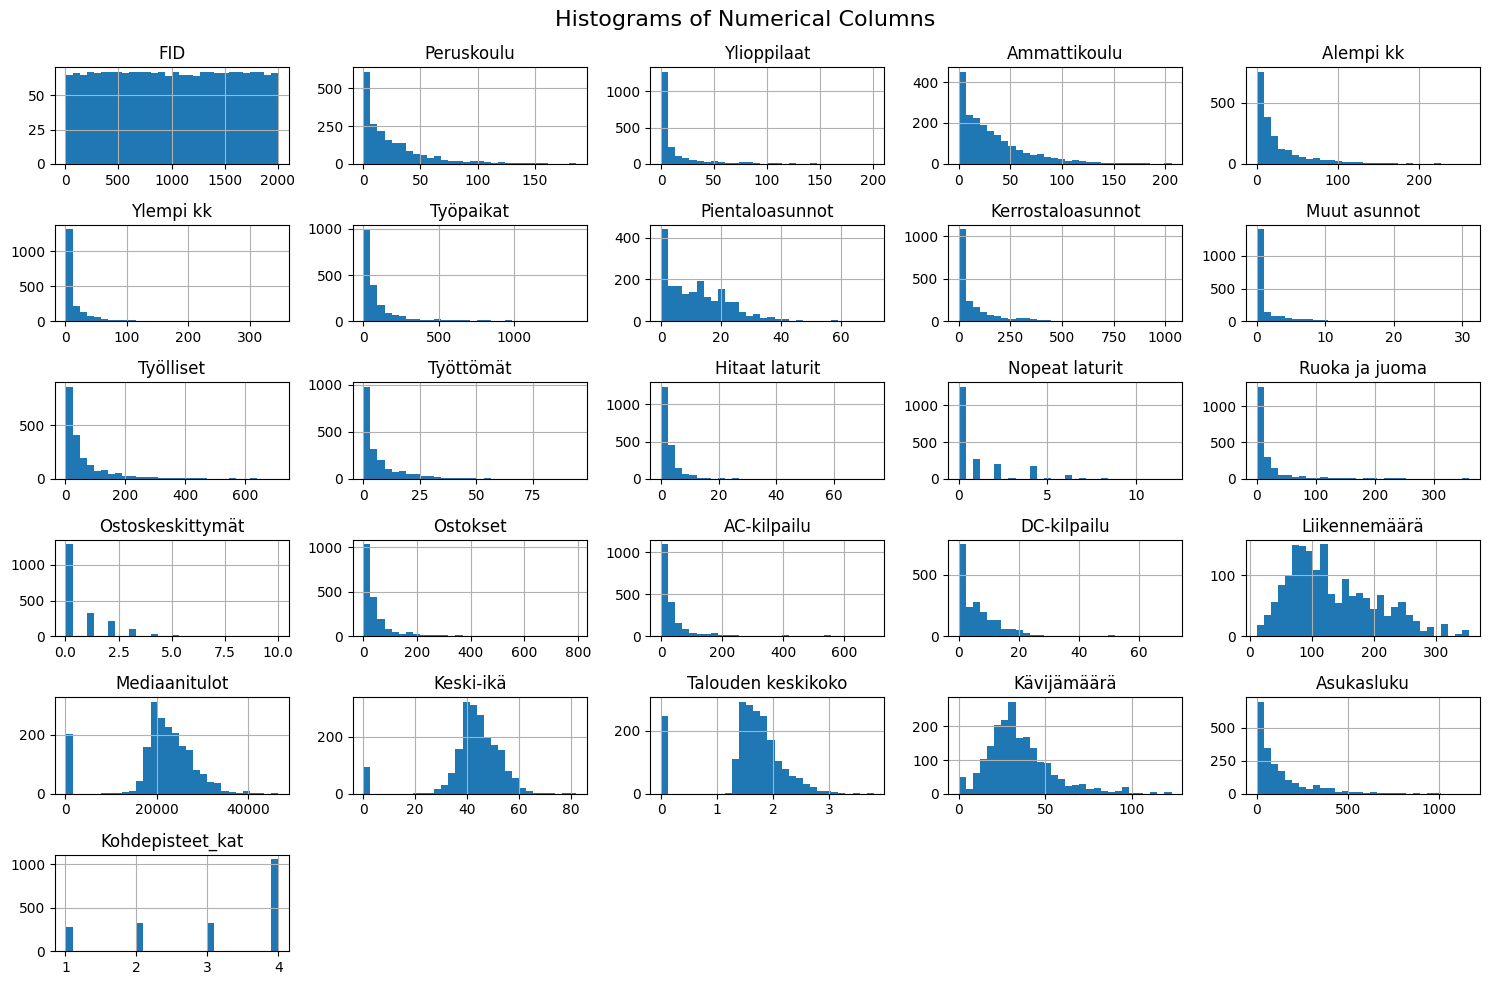

FID                   0.002309
Peruskoulu            1.914612
Ylioppilaat           3.141130
Ammattikoulu          1.521250
Alempi kk             2.477488
Ylempi kk             3.686483
Työpaikat             3.074621
Pientaloasunnot       1.163269
Kerrostaloasunnot     2.701447
Muut asunnot          3.290709
Työlliset             2.953710
Työttömät             2.781540
Hitaat laturit        7.170357
Nopeat laturit        2.115912
Ruoka ja juoma        4.120310
Ostoskeskittymät      2.333516
Ostokset              3.569378
AC-kilpailu           3.827723
DC-kilpailu           2.860225
Liikennemäärä         0.721909
Mediaanitulot        -1.233327
Keski-ikä            -1.977720
Talouden keskikoko   -1.094696
Kävijämäärä           1.228219
Asukasluku            2.297118
Kohdepisteet_kat     -0.763554
Name: skew, dtype: float64


In [254]:
# TO-DO: Sovita kolumneja sopivaan datamuunnos-tyyppiin riippuen vääristymästä (skew)
# Define columns for each type of transformation
sqrt_transform_cols = ["Liikennemäärä", "Kävijämäärä"]
square_transform_cols = []
log_transform_cols = []


df_transformed = df

# Apply Square Root Transformation
for col in sqrt_transform_cols:
    df_transformed[col] = np.sqrt(df[col])

# Apply Square Transformation
for col in square_transform_cols:
    df_transformed[col] = np.square(df[col])

# Apply Log Transformation
for col in log_transform_cols:
    df_transformed[col] = np.log1p(df[col])

# Plot histograms of transformed data
df_transformed.hist(bins=30, figsize=(15, 10))

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Reserve space for suptitle
plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.show()

# Summary statistics for all numerical columns
summary_stats = df_transformed.describe().T
summary_stats['skew'] = df_transformed.skew()
summary_stats['kurtosis'] = df_transformed.kurtosis()

# print(summary_stats)
print(summary_stats['skew'])

df = df_transformed

# Imputation

In [255]:
# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=42)

# Apply imputation
imputed_data = imputer.fit_transform(df)

# Convert back to a DataFrame (if necessary)
imputed_df = pd.DataFrame(imputed_data, columns=df.columns)

# Inspect the results
print(imputed_df.isnull().sum())


FID                   0
Peruskoulu            0
Ylioppilaat           0
Ammattikoulu          0
Alempi kk             0
Ylempi kk             0
Työpaikat             0
Pientaloasunnot       0
Kerrostaloasunnot     0
Muut asunnot          0
Työlliset             0
Työttömät             0
Hitaat laturit        0
Nopeat laturit        0
Ruoka ja juoma        0
Ostoskeskittymät      0
Ostokset              0
AC-kilpailu           0
DC-kilpailu           0
Liikennemäärä         0
Mediaanitulot         0
Keski-ikä             0
Talouden keskikoko    0
Kävijämäärä           0
Asukasluku            0
Kohdepisteet_kat      0
dtype: int64


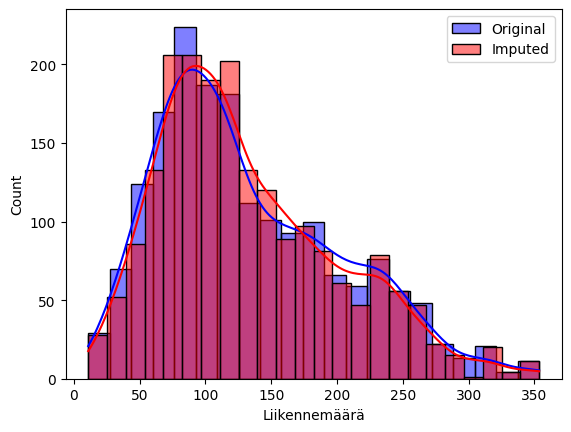

In [256]:
# Visualize the distribution of original and imputed data
sns.histplot(df['Liikennemäärä'].dropna(), color="blue", label="Original", kde=True)
sns.histplot(imputed_df['Liikennemäärä'], color="red", label="Imputed", kde=True)
plt.legend()
plt.show()


In [257]:
df = imputed_df

# Train and test sets

In [258]:
# Initialize and preprocess data
columns_to_drop = ["Nopeat laturit"]
X = df.drop(columns=columns_to_drop)
y = df[["Nopeat laturit"]].values.ravel()



In [259]:
# Keep station IDs before dropping them from feature set
X_with_id = X.copy()  # Make a copy to retain station IDs
X_with_id['FID'] = df.loc[X.index, 'FID']

X = X.drop(["FID"], axis = 1)

In [260]:
X = X.astype(float)

In [261]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Mallien arviointi

In [159]:
# Define models to test
models = {
    'Random Forest': RandomForestRegressor(random_state = 42),
    'Gradient Boosting': GradientBoostingRegressor(random_state = 42),
    'Extra Trees': ExtraTreesRegressor(random_state = 42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(random_state = 42)
}

In [160]:


# Evaluate models
results = []
for name, model in models.items():
    try:
        # Perform cross-validation with MAE scoring
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

        # Fit the model on the entire training data
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        # mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        # rmse = mean_squared_error(y_test, y_pred)  # RMSE is the square root of MSE
        r2 = r2_score(y_test, y_pred)

        # Store results
        results.append({
            'Model': name,
            'Test MAE': mae,
            'Test R^2': r2
        })
    except Exception as e:
        print(f"Error with model {name}: {e}")

# Convert results to a DataFrame for easier comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Test R^2', ascending=False)  # Rank by R^2

# Display the results
print(results_df)



                    Model  Test MAE  Test R^2
0           Random Forest  0.792638  0.414023
1       Gradient Boosting  0.791637  0.403415
4  Hist Gradient Boosting  0.824641  0.393398
3             Extra Trees  0.846332  0.358413
2                AdaBoost  1.754444 -0.484609


# Grid Search

In [262]:
models = {
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# TO-DO: Säätäkää parametreja gridien sisällä vapaasti, default-lukemat melko
# satunnaiset. Kannattaa pitää vaihtoehtojen lukumäärä pienenä, ettei
# suoritusaika veny kauhean pitkäksi.
param_grids = {
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 4],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2]
    },
    'Extra Trees': {
        'n_estimators': [200, 300],
        'max_depth': [None, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 3],
        'max_features': ['sqrt', 'log2', 0.5]
    },
    'Hist Gradient Boosting': {
        'learning_rate': [0.05, 0.1],
        'max_iter': [100, 200],
        'max_depth': [5, 10],
        'l2_regularization': [0.1, 0.5],
        'min_samples_leaf': [10, 20]
    },
    'Random Forest': {
        'n_estimators': [200, 300],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 3],
        'max_features': ['sqrt', 0.5]
    }
}

# TO-DO: Syötä tähän malli, joka suoriutui sinulla parhaiten.
model_name = 'Gradient Boosting'

model = models[model_name]
param_grid = param_grids[model_name]

# Find the best parameters with grid search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate test set metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best parameters for {model_name}: {grid_search.best_params_}")
print("Test Set Mean Absolute Error (MAE): ", mae)
print("Test Set R² Score: ", r2)

Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test Set Mean Absolute Error (MAE):  0.8094186110536835
Test Set R² Score:  0.4172989555500147


# Best model initiation

In [263]:
best_params = grid_search.best_params_

# TO-DO: Vaihda tähän valitsemasi malli
best_model = GradientBoostingRegressor(**best_params, random_state=42)

# Train the model on the entire training data
best_model.fit(X_train, y_train)

# Get predictions for the test data
y_pred = best_model.predict(X_test) # Generate predictions using best_model

# Calculate test set metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set R^2 Score: {r2:.4f}")

Test Set MAE: 0.8094
Test Set R^2 Score: 0.4173


In [264]:
y_pred = best_model.predict(X)

# Convert predictions to a DataFrame
results_df = pd.DataFrame({
    'FID': X_with_id["FID"],
    'actual': y,
    'predicted': y_pred
})

# Calculate different error metrics for each row
results_df['absolute_error'] = np.abs(results_df['actual'] - results_df['predicted'])
results_df['squared_error'] = (results_df['actual'] - results_df['predicted']) ** 2
results_df['percentage_error'] = np.abs(results_df['actual'] - results_df['predicted']) / results_df['actual'] * 100

In [265]:
results_df.sort_values(by = ["actual"])

,FID,actual,predicted,absolute_error,squared_error,percentage_error
1132,1143.0,0.0,0.205237,0.205237,0.042122,inf
1147,1158.0,0.0,1.141210,1.141210,1.302361,inf
1146,1157.0,0.0,0.597247,0.597247,0.356704,inf
1144,1155.0,0.0,0.699985,0.699985,0.489979,inf
1143,1154.0,0.0,0.394768,0.394768,0.155842,inf
...,...,...,...,...,...,...
1926,1944.0,9.0,2.073183,6.926817,47.980792,76.964632
1864,1881.0,10.0,8.538902,1.461098,2.134806,14.610975
1860,1877.0,10.0,8.538902,1.461098,2.134806,14.610975
1863,1880.0,10.0,8.538902,1.461098,2.134806,14.610975


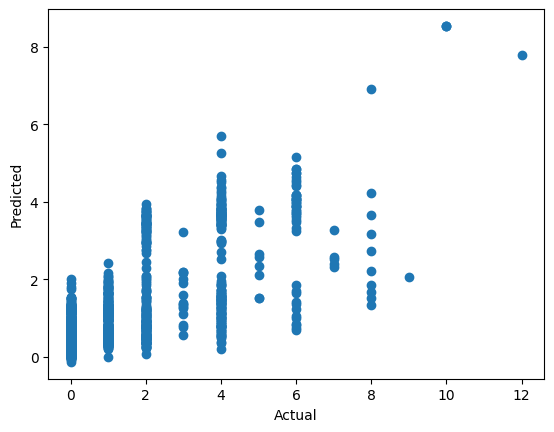

In [266]:
plt.scatter(results_df["actual"], results_df["predicted"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# SHAP initiation

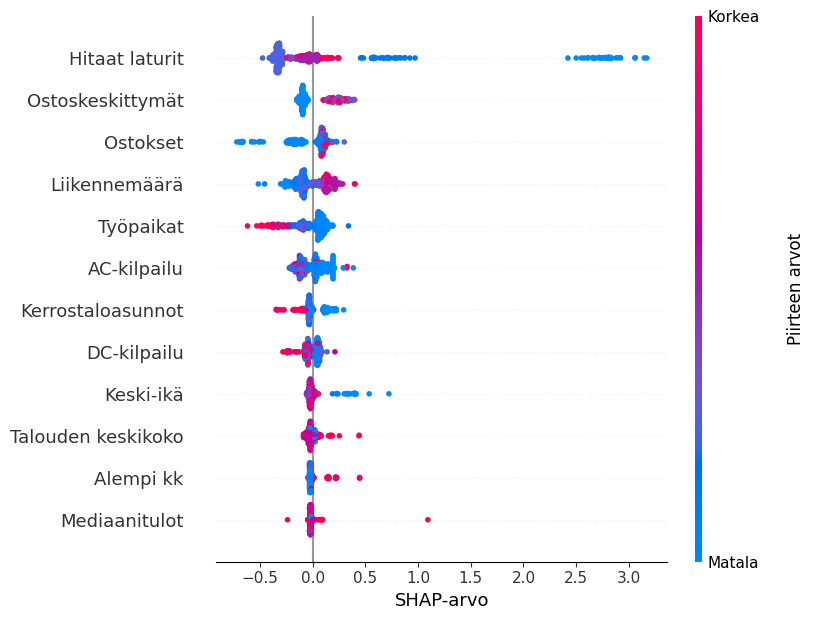

In [267]:
# Initialize the SHAP explainer
explainer = shap.Explainer(best_model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test, check_additivity = False)

# Plot SHAP summary plot (global interpretation)
shap.summary_plot(shap_values, X_test, show = False, max_display = 12, feature_names = X_test.columns)

# Rename the axes
plt.xlabel("SHAP-arvo")

# Access the color bar and modify its label and ticks
cbar = plt.gcf().axes[-1]  # Get the color bar
cbar.set_ylabel('Piirteen arvot', rotation=90, labelpad=20)
cbar.set_yticklabels(['Matala', 'Korkea'])  # Rename low and high

# Show the plot
plt.show()


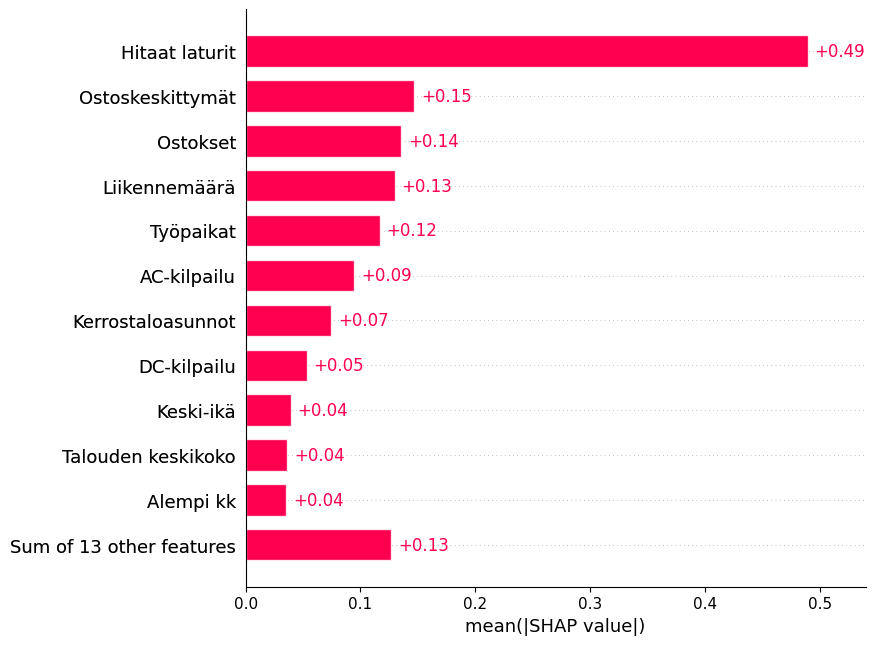

In [268]:
# Overall feature importance
shap.plots.bar(shap_values, max_display = 12)

# Dependence plots

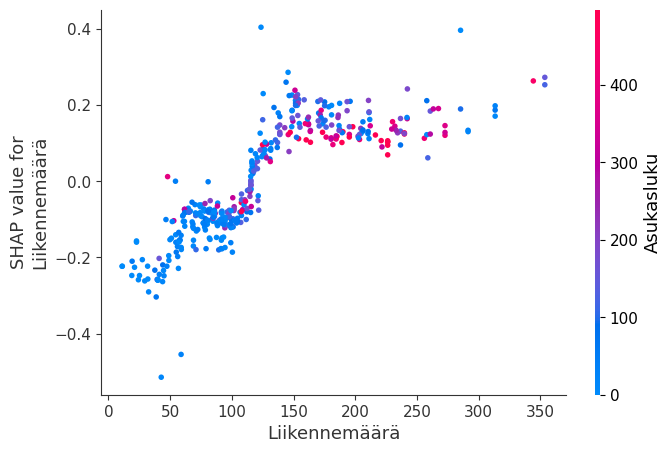

In [274]:
# Initialize SHAP dependence plot
shap.dependence_plot('Liikennemäärä', shap_values.values, X_test, interaction_index="Asukasluku")

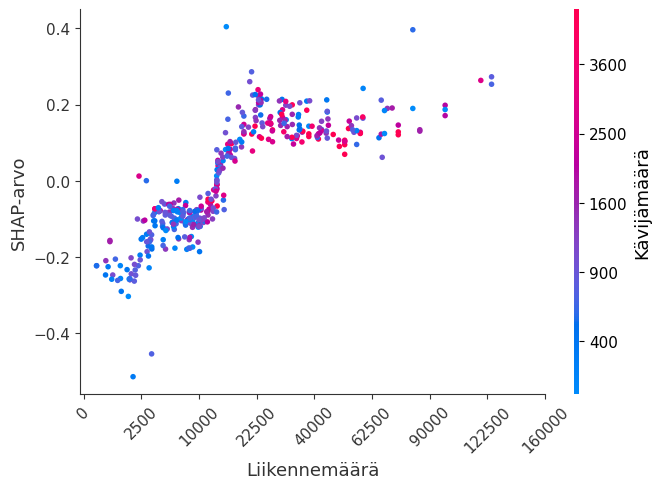

In [275]:
shap.dependence_plot('Liikennemäärä', shap_values.values, X_test, interaction_index="Kävijämäärä", show = False)

# Rename the axes
plt.ylabel("SHAP-arvo")

# Get the current axis
ax = plt.gca()

# Modify x-axis to show original values by taking the square root
xticks = ax.get_xticks()  # Get the current tick positions on x-axis

# Set fewer ticks using linspace: np.linspace(min, max, num_ticks)
num_ticks = 10  # Adjust this to control how many ticks you want
xtick_values = np.linspace(min(xticks), max(xticks), num_ticks)

ax.set_xticks(xtick_values)  # Set the tick positions explicitly
ax.set_xticklabels([f'{tick**2:.0f}' if tick >= 0 else '' for tick in xtick_values])  # Apply the correct transformation

# Handle the color bar
colorbar = ax.collections[0].colorbar

# Format the tick labels using FuncFormatter, applying square transformation on the tick values
def squared_format(x, pos):
   return f'{x**2:.0f}'  # Square and format without decimals

# Set the formatter without touching the tick positions
colorbar.ax.yaxis.set_major_formatter(FuncFormatter(squared_format))

# Adjust the x-axis limits to avoid excess empty space
plt.xlim(left=-3)  # You can set this to `left=np.min(transformed_values)` if needed

# Rotate x-axis tick labels to make them more readable
plt.xticks(rotation=45)  # Rotate the x-axis tick labels by 45 degrees

# Show the plot
plt.show()

In [271]:
# TO-DO: valitse oma piirre, jolle piirrät haluamasi piirteen kanssa
# riippuvuuskäyrän. Kokeile myös alkuperäisten lukujen laskemista.

feature_to_analyze = ""
interaction_feature = ""
# TO-DO: Ota pois kommentointi, kun olet valinnut haluamasi piirteet
# shap.dependence_plot(feature_to_analyze, shap_values.values, X_test, interaction_index=interaction_feature)

# Partial dependence plots

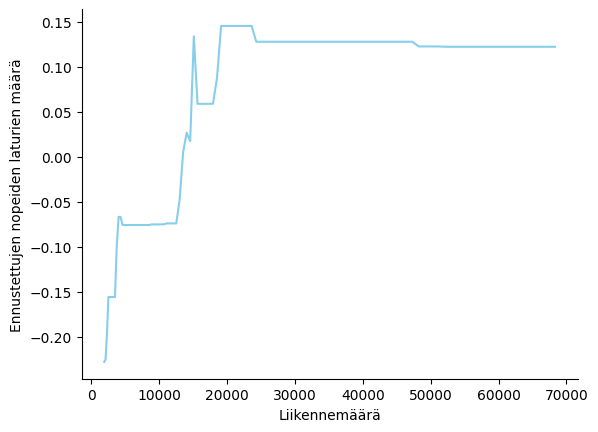

In [272]:
# The feature being analyzed
feature = 'Liikennemäärä'

# Get the feature index
feature_index = list(X_train.columns).index(feature)

# Calculate partial dependence for the feature
pdp_results = partial_dependence(best_model, X_train, [feature_index])

# Extract feature values and partial dependence predictions
x_transformed = pdp_results['grid_values'][0]
y_values = pdp_results['average'][0]

# TO-DO: muuta arvot alkuperäisiin kumoamalla tehdyt transformaatiot
x_original = x_transformed ** 2

# Now manually plot the PDP using original feature values
plt.plot(x_original, y_values, color = "skyblue")

# Customize the plot
plt.xlabel(f"{feature}")
plt.ylabel("Ennustettujen nopeiden laturien määrä")

# Remove the borders (spines)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Display the plot
plt.show()


In [273]:
# TO-DO: piirrä valitsemallesi piirteelle myös osittainen riippuvuuskäyrä.